<a href="https://colab.research.google.com/github/SynapticOverflow/Prototype-3/blob/main/T4_FUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

Running 150 Monte Carlo simulations for tay-sachs (T4+FUS)...
  Completed 15/150 trials
  Completed 30/150 trials
  Completed 45/150 trials
  Completed 60/150 trials
  Completed 75/150 trials
  Completed 90/150 trials
  Completed 105/150 trials
  Completed 120/150 trials
  Completed 135/150 trials
  Completed 150/150 trials
Monte Carlo simulation complete!

Generating plots...
Day 0: GM2 890.0 ± 0.0 nmol/g | GMFM 45.0 ± 0.0 | E_expr 0.020
Day 90: GM2 482.3 ± 295.3 nmol/g | GMFM 29.8 ± 9.8 | E_expr 0.013
Day 180: GM2 289.3 ± 174.8 nmol/g | GMFM 36.1 ± 9.4 | E_expr 0.009
Day 365: GM2 179.6 ± 76.1 nmol/g | GMFM 41.6 ± 6.7 | E_expr 0.004


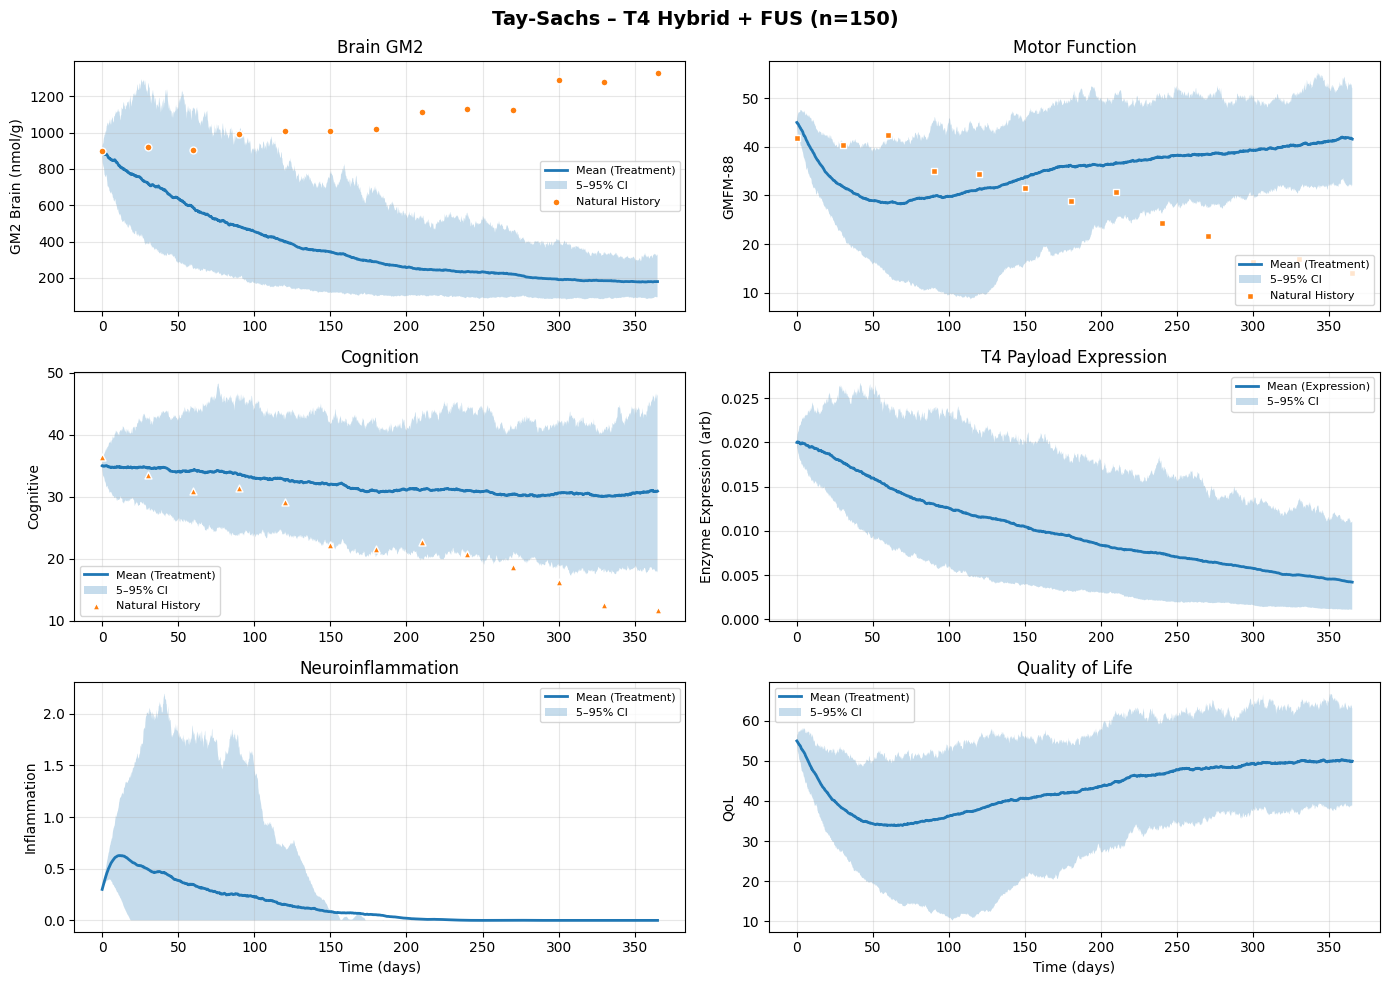

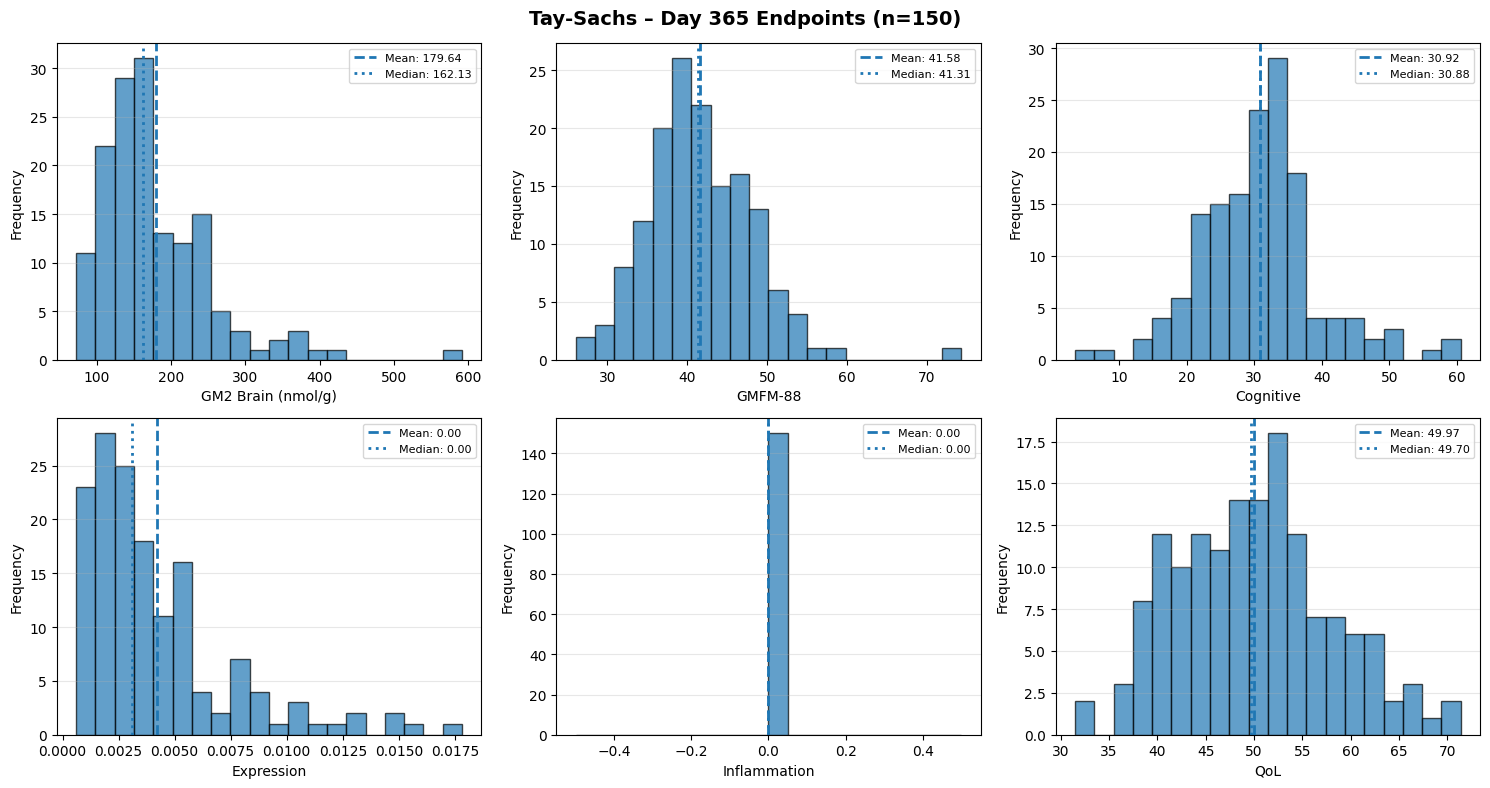

In [4]:
# gm2_sde_simulator_t4_fus.py
"""
GM2 SDE Simulator — T4 Hybrid Vector + Focused Ultrasound (BBB opening)
-----------------------------------------------------------------------
This recode replaces AAV with a bacteriophage T4-based hybrid viral vector
for large-gene/protein delivery and adds focused ultrasound (FUS) sessions
that transiently increase BBB permeability for both small molecules and
vector brain entry/transduction.

- Stochastic simulator using a diagonal Milstein scheme
- Two diseases: Tay-Sachs (default) and Sandhoff
- Oral substrate reduction therapy (SRT) retained (e.g., Genz-529468)
- T4 vector parameters: circulation, brain entry, payload expression/decay
- FUS events: time-local BBB permeability multiplier
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Any

# -------------------------
# Disease-specific baseline factory
# -------------------------
def disease_params(disease: str = 'tay-sachs') -> Dict[str, float]:
    d = disease.lower()
    if d in ('sandhoff', 'sandhof', 'sandhoff disease'):
        return {
            'name': 'Sandhoff',
            'baseline_gm2_brain': 1450.0,
            'baseline_gm2_liver': 280.0,
            'residual_hexa': 0.018,
            'residual_hexb': 0.0,
            'gm2_synth': 2.8,
            'gm2_km_brain': 85.0,
            'gm2_km_liver': 65.0,
            'vmax_brain': 12.5,
            'vmax_liver': 18.0,
            'inf_threshold': 800.0,
            'gmfm_baseline': 35.0,
            'cognitive_baseline': 25.0,
            'seizure_baseline': 8.5,
            'respiratory_baseline': 65.0,
            'qol_baseline': 40.0,
        }
    else:
        # Tay-Sachs default
        return {
            'name': 'Tay-Sachs',
            'baseline_gm2_brain': 890.0,
            'baseline_gm2_liver': 156.0,
            'residual_hexa': 0.0,
            'residual_hexb': 0.85,
            'gm2_synth': 2.3,
            'gm2_km_brain': 75.0,
            'gm2_km_liver': 55.0,
            'vmax_brain': 12.5,
            'vmax_liver': 18.0,
            'inf_threshold': 650.0,
            'gmfm_baseline': 45.0,
            'cognitive_baseline': 35.0,
            'seizure_baseline': 3.2,
            'respiratory_baseline': 75.0,
            'qol_baseline': 55.0,
        }

# -------------------------
# Utility functions
# -------------------------
def hill(B: float, IC50: float, Emax: float, n: float) -> float:
    """Hill Emax inhibition for SRT vs GM2 synthesis."""
    num = Emax * (B ** n)
    den = (IC50 ** n) + (B ** n) + 1e-12
    return num / den

def mm_clearance(S: float, E_eff: float, vmax: float, km: float, ki: Optional[float] = None) -> float:
    if ki is None:
        return (vmax * E_eff * S) / (km + S + 1e-12)
    else:
        return (vmax * E_eff * S) / (km + S + (S ** 2 / ki) + 1e-12)

def dose_pulse_smooth(t_days: float, dose_mg: float, admin_times_per_day: int = 2) -> float:
    """Smooth twice-daily oral dosing (Gaussian pulses within each day)."""
    frac = t_days - np.floor(t_days)
    pulses = 0.0
    for p in np.linspace(0, 1, admin_times_per_day, endpoint=False):
        pulses += dose_mg * np.exp(-((frac - p) / 0.03) ** 2)
    return pulses

# -------------------------
# FUS BBB-opening
# -------------------------
@dataclass
class FUSEvent:
    day: float                  # center day of FUS session
    duration_hours: float = 1.0 # active window (approx)
    gain: float = 1.5           # multiplicative increase in BBB permeability (>=0)
    smooth_tau_hours: float = 0.5  # smooth roll-on/off

    def multiplier(self, t_day: float) -> float:
        """Return a smooth bell-shaped multiplier centered at `day`."""
        # Convert hours to days
        tau = max(1e-6, self.smooth_tau_hours / 24.0)
        width = max(1e-6, self.duration_hours / 24.0)
        # Gaussian-shaped window
        return 1.0 + self.gain * np.exp(-0.5 * ((t_day - self.day) / (width / 2.355 + tau)) ** 2)

def fus_multiplier(t_day: float, events: Optional[List[FUSEvent]]) -> float:
    if not events:
        return 1.0
    m = 1.0
    for ev in events:
        m = max(m, ev.multiplier(t_day))
    return m

# -------------------------
# Model parameterization (includes T4 vector block)
# -------------------------
def make_base_params(disease: str) -> Dict[str, Any]:
    dp = disease_params(disease)
    base = {
        # PK (oral SRT)
        'Vd': 2.1,
        'ka': 1.2,        # 1/day
        'F': 0.85,
        'k_el': 0.035,
        'k_p2b': 0.12,    # plasma->brain
        'k_b2p': 0.015,   # brain->plasma
        'k_brain_elim': 0.15,
        'IC50': 50.0,
        'Emax': 0.6,
        'hill_n': 1.2,
        'protein_binding': 0.15,
        'Kp_uu': 0.12,    # baseline brain partition

        # T4 hybrid vector (replaces AAV)
        'T4_clear': 0.002,        # systemic clearance (1/day)
        'k_T4_entry': 2e-8,       # brain cell entry per particle (scaled)
        'k_T4_payload': 1/25.0,   # rate to active enzyme from entry
        'k_T4_decay': 1/240.0,    # loss of expression (slower than AAV)
        'expr_cap': 8.0,          # T4 allows larger payload/expression ceiling

        # GM2 & inflammation & clinical
        'gm2_synth': dp['gm2_synth'],
        'vmax_brain': dp['vmax_brain'],
        'km_brain': dp['gm2_km_brain'],
        'vmax_liver': dp['vmax_liver'],
        'km_liver': dp['gm2_km_liver'],
        'inf_threshold': dp['inf_threshold'],
        'k_inf': 0.2,
        'k_res': 0.05,
        'gmfm_baseline': dp['gmfm_baseline'],
        'cog_baseline': dp['cognitive_baseline'],
        'seiz_baseline': dp['seizure_baseline'],
        'resp_baseline': dp['respiratory_baseline'],
        'qol_baseline': dp['qol_baseline'],

        # damage rates
        'rho_g': 1e-3,
        'rho_i': 1e-2,

        # noise (fractional, diagonal)
        'sigma_Agut': 0.05,
        'sigma_p': 0.12,
        'sigma_b': 0.10,
        'sigma_t4': 0.08,
        'sigma_entry': 0.05,
        'sigma_e': 0.04,
        'sigma_g': 0.06,
        'sigma_i': 0.05,
        'sigma_cl': 0.03,

        # BBB/FUS coupling factors
        'fus_uptake_gain_scale': 1.0,  # scales how FUS alters k_p2b
        'fus_entry_gain_scale': 1.5,   # scales how FUS alters k_T4_entry to brain cells
    }
    base.update(dp)
    return base

# -------------------------
# Drift and diffusion
# State vector X:
# [A_gut, P, B, T4_sys, T4_entry, E_expr, G_brain, G_liver, I, D, GMFM, COG, SEIZ, RESP, QOL, Ab]
# Ab ~ anti-phage antibody titer (adaptive immunity proxy)
# -------------------------
def drift_full(x: np.ndarray, t: float, dose_mg: float, params: Dict[str, Any],
               t4_admin_day: Optional[float] = None, t4_admin_particles: float = 0.0,
               fus_events: Optional[List[FUSEvent]] = None) -> np.ndarray:
    A_gut, P, B, T4_sys, T4_ent, E_expr, G_B, G_L, I, D, GMFM, COG, SEIZ, RESP, QOL, Ab = x

    # FUS multiplier at time t
    m_fus = fus_multiplier(t, fus_events)

    # Optional bolus of T4 at admin day (instantaneous add to systemic pool)
    if t4_admin_day is not None:
        if abs(t - t4_admin_day) < 1e-6:
            T4_sys += t4_admin_particles

    # Oral dosing into gut
    A_add = dose_pulse_smooth(t, dose_mg)
    dA = -params['ka'] * A_gut + A_add

    # Plasma PK (SRT)
    dP = params['F'] * params['ka'] * A_gut - (params['k_el'] + params['k_p2b']) * P + params['k_b2p'] * B

    # Brain PK (SRT), permeability enhanced by FUS (scaled on plasma->brain leg)
    k_p2b_eff = params['k_p2b'] * (1.0 + params['fus_uptake_gain_scale'] * (m_fus - 1.0))
    dB = k_p2b_eff * P - params['k_brain_elim'] * B

    # Free fraction for PD
    B_free = B * (1.0 - params['protein_binding'])

    # T4 systemic vector
    # Clearance + entry sink (entry into brain cells proportional to FUS-enhanced entry)
    k_entry_eff = params['k_T4_entry'] * (1.0 + params['fus_entry_gain_scale'] * (m_fus - 1.0))
    dT4_sys = -params['T4_clear'] * T4_sys - k_entry_eff * T4_sys

    # T4 entry "fraction of target cells transduced/engaged" proxy (0..1)
    dT4_ent = k_entry_eff * T4_sys * (1.0 - T4_ent) - 0.001 * T4_ent  # slow natural loss

    # Expression dynamics (allowing higher cap with T4 payload)
    dE = params['k_T4_payload'] * T4_ent * (params['expr_cap'] - E_expr) - params['k_T4_decay'] * E_expr

    # GM2 dynamics
    inhib = hill(B_free, params['IC50'], params['Emax'], params['hill_n'])
    synth = params['gm2_synth']
    brain_clear = mm_clearance(G_B, params['residual_hexa'] + E_expr, params['vmax_brain'], params['km_brain'])
    liver_clear = mm_clearance(G_L, params['residual_hexa'] + E_expr, params['vmax_liver'], params['km_liver'])
    dG_B = synth * (1 - inhib) - brain_clear - 0.01 * G_B
    dG_L = 0.7 * synth * (1 - inhib) - liver_clear - 0.05 * G_L

    # Inflammation
    trigger = max(0.0, (G_B - params['inf_threshold']) / params['inf_threshold'])
    anti_inf = 0.15 * inhib + 0.05 * (params['residual_hexa'] + E_expr)
    dI = params['k_inf'] * trigger - params['k_res'] * I - anti_inf

    # Damage
    dD = params['rho_g'] * max(0.0, G_B - params['inf_threshold']) + params['rho_i'] * I - 0.0001 * D

    # Clinical observables (first-order towards targets)
    gm2_factor = max(0.01, 1 - (G_B / 2000.0))
    infl_factor = max(0.01, 1 - I)
    enzyme_factor = min(3.0, 1 + (params['residual_hexa'] + E_expr))  # higher cap since T4
    targ_GMFM = params['gmfm_baseline'] * gm2_factor * infl_factor * enzyme_factor
    targ_COG = params['cog_baseline'] * np.exp(-0.01 * D) * enzyme_factor
    targ_SEIZ = params['seiz_baseline'] / (1 + 0.6 * (params['residual_hexa'] + E_expr))
    targ_RESP = params['resp_baseline'] * gm2_factor * enzyme_factor
    targ_QOL = params['qol_baseline'] * gm2_factor * infl_factor
    k_clin = 0.02
    dGMFM = k_clin * (targ_GMFM - GMFM)
    dCOG = k_clin * 0.6 * (targ_COG - COG)
    dSEIZ = 0.03 * (targ_SEIZ - SEIZ)
    dRESP = 0.025 * (targ_RESP - RESP)
    dQOL = 0.02 * (targ_QOL - QOL)

    # Anti-phage antibodies (very simple adaptive response proxy)
    dAb = 0.015 * (T4_sys > 0) - 0.01 * Ab

    return np.array([dA, dP, dB, dT4_sys, dT4_ent, dE, dG_B, dG_L, dI, dD, dGMFM, dCOG, dSEIZ, dRESP, dQOL, dAb], dtype=float)

def diffusion_full(x: np.ndarray, t: float, params: Dict[str, Any]) -> np.ndarray:
    A_gut, P, B, T4_sys, T4_ent, E_expr, G_B, G_L, I, D, GMFM, COG, SEIZ, RESP, QOL, Ab = x
    b = np.zeros_like(x)
    b[0]  = params['sigma_Agut'] * max(1e-8, A_gut)
    b[1]  = params['sigma_p'] * max(1e-8, P)
    b[2]  = params['sigma_b'] * max(1e-8, B)
    b[3]  = params['sigma_t4'] * max(1e-8, T4_sys)
    b[4]  = params['sigma_entry'] * max(1e-8, T4_ent)
    b[5]  = params['sigma_e'] * max(1e-8, E_expr)
    b[6]  = params['sigma_g'] * max(1e-8, G_B)
    b[7]  = params['sigma_g'] * max(1e-8, G_L)
    b[8]  = params['sigma_i'] * max(1e-8, I)
    b[9]  = 0.005 * max(1e-8, D)
    b[10] = params['sigma_cl'] * max(1e-8, GMFM)
    b[11] = params['sigma_cl'] * max(1e-8, COG)
    b[12] = params['sigma_cl'] * max(1e-8, SEIZ)
    b[13] = params['sigma_cl'] * max(1e-8, RESP)
    b[14] = params['sigma_cl'] * max(1e-8, QOL)
    b[15] = 0.02 * max(1e-8, Ab)
    return b

# -------------------------
# Milstein integrator (diagonal)
# -------------------------
def simulate_milstein_full(x0: np.ndarray, tmax_days: float, dt: float, dose_mg: float,
                           disease: str = 'tay-sachs',
                           t4_admin_day: Optional[float] = None, t4_admin_particles: float = 0.0,
                           fus_events: Optional[List[FUSEvent]] = None,
                           seed: Optional[int] = None, corr: Optional[np.ndarray] = None,
                           params_override: Optional[Dict[str, Any]] = None) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    base_params = make_base_params(disease)
    if params_override:
        base_params.update(params_override)
    params = base_params

    n_steps = int(np.ceil(tmax_days / dt)) + 1
    times = np.linspace(0, tmax_days, n_steps)
    dim = len(x0)
    X = np.zeros((n_steps, dim))
    X[0, :] = x0.copy()

    if corr is None:
        corr = np.eye(dim)
    L = np.linalg.cholesky(corr + 1e-12 * np.eye(dim))
    sqrt_dt = np.sqrt(dt)

    for i in range(1, n_steps):
        t = times[i - 1]
        x = X[i - 1, :].copy()
        f = drift_full(x, t, dose_mg, params, t4_admin_day=t4_admin_day,
                       t4_admin_particles=t4_admin_particles, fus_events=fus_events)
        b = diffusion_full(x, t, params)
        z = rng.standard_normal(dim)
        dW = (L @ z) * sqrt_dt
        x_new = np.zeros_like(x)
        for j in range(dim):
            drift_term = f[j] * dt
            diff_term = b[j] * dW[j]
            eps = 1e-9
            local_sigma = b[j] / max(abs(x[j]), eps)
            milstein_corr = 0.5 * local_sigma * b[j] * ((dW[j] ** 2) - dt)
            x_new[j] = x[j] + drift_term + diff_term + milstein_corr

        # bounds
        x_new[0] = max(x_new[0], 0.0)           # A_gut
        x_new[1] = max(x_new[1], 0.0)           # P
        x_new[2] = max(x_new[2], 0.0)           # B
        x_new[3] = max(x_new[3], 0.0)           # T4_sys
        x_new[4] = np.clip(x_new[4], 0.0, 1.0)  # T4_entry fraction
        x_new[5] = np.clip(x_new[5], 0.0, params['expr_cap'])  # E_expr
        x_new[6] = max(x_new[6], 0.0)           # G_B
        x_new[7] = max(x_new[7], 0.0)           # G_L
        x_new[8] = max(x_new[8], 0.0)           # I
        x_new[9] = max(x_new[9], 0.0)           # D
        x_new[10] = np.clip(x_new[10], -20.0, 100.0)
        x_new[11] = np.clip(x_new[11], -20.0, 150.0)
        x_new[12] = max(x_new[12], 0.0)
        x_new[13] = np.clip(x_new[13], 0.0, 150.0)
        x_new[14] = np.clip(x_new[14], 0.0, 100.0)
        x_new[15] = max(x_new[15], 0.0)

        X[i, :] = x_new

    cols = ["A_gut","plasma","brain_drug","T4_sys","T4_entry","E_expr","gm2_brain","gm2_liver","inflammation","damage",
            "gmfm88","cognitive","seizures_week","respiratory","quality_of_life","anti_phage_ab"]
    df = pd.DataFrame(X, columns=cols)
    df["time_days"] = times

    # Derived observables
    df["csf_gm2"] = df["gm2_brain"] * 0.03 + 0.1 * rng.normal(size=len(df))
    df["nfl"] = 15.0 + df["inflammation"] * 115.0 + rng.normal(0, 2, size=len(df))
    df["il6"] = 125 * (1 + df["inflammation"] * 3.2) * (1 + 0.1 * np.sin(2 * np.pi * df["time_days"])) + rng.normal(0, 5, size=len(df))
    return df

# -------------------------
# Monte Carlo
# -------------------------
def run_monte_carlo(n_trials: int = 200, disease: str = 'tay-sachs', tmax_days: float = 365.0, dt: float = 0.1,
                    dose_mg: float = 50.0, t4_admin_day: Optional[float] = 30.0, t4_admin_particles: float = 5e12,
                    fus_events: Optional[List[FUSEvent]] = None,
                    base_seed: int = 42, params_override: Optional[Dict[str, Any]] = None) -> List[pd.DataFrame]:

    params = make_base_params(disease)
    if params_override:
        params.update(params_override)

    def make_x0(p: Dict[str, Any]) -> np.ndarray:
        return np.array([
            0.0,                          # A_gut
            0.0,                          # plasma
            0.0,                          # brain_drug
            0.0,                          # T4_sys
            0.0,                          # T4_entry
            0.02,                         # E_expr baseline
            p['baseline_gm2_brain'],      # gm2_brain
            p['baseline_gm2_liver'],      # gm2_liver
            0.3,                          # inflammation
            0.0,                          # damage
            p['gmfm_baseline'],           # gmfm88
            p['cognitive_baseline'],      # cognitive
            p['seizure_baseline'],        # seizures/week
            p['respiratory_baseline'],    # respiratory
            p['qol_baseline'],            # quality of life
            0.0                           # anti-phage antibodies
        ], dtype=float)

    x0 = make_x0(params)
    dim = len(x0)
    corr = np.eye(dim)
    corr[1, 2] = corr[2, 1] = 0.35    # plasma-brain drug correlation
    corr[5, 6] = corr[6, 5] = -0.2    # enzyme vs GM2 anti-correlation

    results: List[pd.DataFrame] = []
    print(f"Running {n_trials} Monte Carlo simulations for {disease} (T4+FUS)...")
    for i in range(n_trials):
        if (i + 1) % max(1, n_trials // 10) == 0:
            print(f"  Completed {i + 1}/{n_trials} trials")
        seed = base_seed + i
        df = simulate_milstein_full(x0, tmax_days, dt, dose_mg, disease=disease,
                                    t4_admin_day=t4_admin_day, t4_admin_particles=t4_admin_particles,
                                    fus_events=fus_events, seed=seed, corr=corr, params_override=params_override)
        df['trial'] = i
        results.append(df)

    print("Monte Carlo simulation complete!")
    return results

def summarize_monte_carlo(results: List[pd.DataFrame], time_points: Optional[np.ndarray] = None) -> pd.DataFrame:
    if time_points is None:
        time_points = results[0]['time_days'].values
    all_data = pd.concat(results, ignore_index=True)
    def p05(x): return np.percentile(x, 5)
    def p95(x): return np.percentile(x, 95)
    summary = all_data.groupby('time_days').agg(['mean', 'std', p05, p95])
    # Flatten columns
    summary.columns = ['{}_{}'.format(col[0], col[1] if isinstance(col[1], str) else col[1].__name__) for col in summary.columns.values]
    summary = summary.reset_index()
    return summary

# -------------------------
# Plotting
# -------------------------
def plot_monte_carlo_results(results: List[pd.DataFrame], disease_name: str, validation_data: Optional[Dict[str, Any]] = None):
    summary = summarize_monte_carlo(results)

    fig, axs = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'{disease_name} – T4 Hybrid + FUS (n={len(results)})', fontsize=14, fontweight='bold')

    # Helper to draw mean + CI
    def draw(ax, key, label, color):
        ax.plot(summary['time_days'], summary[f'{key}_mean'], linewidth=2, label=f'Mean ({label})')
        ax.fill_between(summary['time_days'], summary[f'{key}_p05'], summary[f'{key}_p95'], alpha=0.25, label='5–95% CI')
        ax.grid(True, alpha=0.3)

    # Panels
    ax = axs[0, 0]
    draw(ax, 'gm2_brain', 'Treatment', 'r')
    if validation_data and 'gm2_brain' in validation_data:
        ax.scatter(validation_data['gm2_brain']['days'], validation_data['gm2_brain']['values'],
                   s=25, marker='o', zorder=5, edgecolors='white', linewidths=1, label='Natural History')
    ax.set_ylabel('GM2 Brain (nmol/g)'); ax.set_title('Brain GM2'); ax.legend(fontsize=8)

    ax = axs[0, 1]
    draw(ax, 'gmfm88', 'Treatment', 'b')
    if validation_data and 'gmfm88' in validation_data:
        ax.scatter(validation_data['gmfm88']['days'], validation_data['gmfm88']['values'],
                   s=25, marker='s', zorder=5, edgecolors='white', linewidths=1, label='Natural History')
    ax.set_ylabel('GMFM-88'); ax.set_title('Motor Function'); ax.legend(fontsize=8)

    ax = axs[1, 0]
    draw(ax, 'cognitive', 'Treatment', 'orange')
    if validation_data and 'cognitive' in validation_data:
        ax.scatter(validation_data['cognitive']['days'], validation_data['cognitive']['values'],
                   s=25, marker='^', zorder=5, edgecolors='white', linewidths=1, label='Natural History')
    ax.set_ylabel('Cognitive'); ax.set_title('Cognition'); ax.legend(fontsize=8)

    ax = axs[1, 1]
    draw(ax, 'E_expr', 'Expression', 'g')
    ax.set_ylabel('Enzyme Expression (arb)'); ax.set_title('T4 Payload Expression'); ax.legend(fontsize=8)

    ax = axs[2, 0]
    draw(ax, 'inflammation', 'Treatment', 'm')
    ax.set_ylabel('Inflammation'); ax.set_title('Neuroinflammation'); ax.set_xlabel('Time (days)'); ax.legend(fontsize=8)

    ax = axs[2, 1]
    draw(ax, 'quality_of_life', 'Treatment', 'c')
    ax.set_ylabel('QoL'); ax.set_title('Quality of Life'); ax.set_xlabel('Time (days)'); ax.legend(fontsize=8)

    plt.tight_layout()
    return fig

def plot_endpoint_distributions(results: List[pd.DataFrame], disease_name: str):
    endpoints = {k: [] for k in ['gm2_brain','gmfm88','cognitive','E_expr','inflammation','quality_of_life']}
    for df in results:
        final = df.iloc[-1]
        for k in endpoints.keys():
            endpoints[k].append(final[k])

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'{disease_name} – Day 365 Endpoints (n={len(results)})', fontsize=14, fontweight='bold')

    titles = ['GM2 Brain (nmol/g)', 'GMFM-88', 'Cognitive', 'Expression', 'Inflammation', 'QoL']
    keys = list(endpoints.keys())
    for idx, (k, title) in enumerate(zip(keys, titles)):
        ax = axs[idx // 3, idx % 3]
        data = np.array(endpoints[k])
        n, bins, patches = ax.hist(data, bins=20, alpha=0.7, edgecolor='black')
        mean_val = np.mean(data); median_val = np.median(data)
        ax.axvline(mean_val, linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, linestyle=':', linewidth=2, label=f'Median: {median_val:.2f}')
        ax.set_xlabel(title); ax.set_ylabel('Frequency'); ax.legend(fontsize=8); ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    return fig

# -------------------------
# Example runner
# -------------------------
def run_example():
    # Example natural-history validation (noisy, illustrative only)
    rng = np.random.default_rng(888)
    validation_data = {
        'tay-sachs': {
            'gm2_brain': {'days': [0,30,60,90,120,150,180,210,240,270,300,330,365],
                          'values': (np.array([890,905,925,950,980,1015,1055,1095,1140,1185,1230,1280,1330]) + rng.normal(0,35,13)).tolist()},
            'gmfm88':    {'days': [0,30,60,90,120,150,180,210,240,270,300,330,365],
                          'values': (np.array([45,43,41,38,36,33,30,28,25,23,20,18,15]) + rng.normal(0,2,13)).tolist()},
            'cognitive': {'days': [0,30,60,90,120,150,180,210,240,270,300,330,365],
                          'values': (np.array([35,33,31,29,27,25,23,21,19,17,15,13,11]) + rng.normal(0,2,13)).tolist()},
        }
    }

    # FUS sessions (e.g., at 30, 60, 90 days)
    fus_events = [
        FUSEvent(day=30.0, duration_hours=1.0, gain=1.8),
        FUSEvent(day=60.0, duration_hours=1.0, gain=1.6),
        FUSEvent(day=90.0, duration_hours=1.0, gain=1.5),
    ]

    # Monte Carlo (kept modest for demo)
    results_tay = run_monte_carlo(
        n_trials=150,
        disease='tay-sachs',
        tmax_days=365.0,
        dt=0.2,
        dose_mg=50.0,
        t4_admin_day=29.9,            # vector given just before first FUS
        t4_admin_particles=5e12,
        fus_events=fus_events,
        base_seed=42
    )

    print("\nGenerating plots...")
    fig1 = plot_monte_carlo_results(results_tay, 'Tay-Sachs', validation_data['tay-sachs'])
    fig2 = plot_endpoint_distributions(results_tay, 'Tay-Sachs')

    # Print a few summary stats
    summary = summarize_monte_carlo(results_tay)
    for day in [0, 90, 180, 365]:
        row = summary.loc[np.isclose(summary['time_days'], day)]
        if not row.empty:
            print(f"Day {day}: GM2 {row['gm2_brain_mean'].values[0]:.1f} ± {row['gm2_brain_std'].values[0]:.1f} nmol/g | "
                  f"GMFM {row['gmfm88_mean'].values[0]:.1f} ± {row['gmfm88_std'].values[0]:.1f} | "
                  f"E_expr {row['E_expr_mean'].values[0]:.3f}")

    plt.show()
    return results_tay

if __name__ == "__main__":
    run_example()
